In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from dipy.core.geometry import vec2vec_rotmat

from disimpy import simulations, gradients, utils

### Free diffusion

Initiating simulation. Step length = 3.11E-06
Simulation finished.


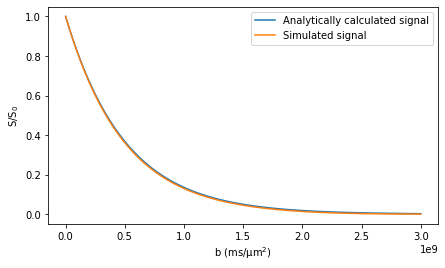

In [7]:
# Define simulation parameters

n_s = int(1e4) # Number of random walkers
n_t = int(1e2) # Number of time points
bs = np.linspace(1, 3e9, 100) # b-values
diffusivity = 2e-9 # In units of m^2/s


# Define gradient array

gradient_file = 'disimpy/tests/example_gradient.txt'
gradient = np.loadtxt(gradient_file)[np.newaxis,:,:]
gradient = np.concatenate([gradient for _ in bs], axis=0)
T = 80e-3 # Duration of gradient in seconds
dt = T/(gradient.shape[1]-1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)


# Run simulation

substrate = {'type' : 'free'}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Compare simulated results to analytically calculated signal

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(bs, np.exp(-bs*diffusivity))
ax.plot(bs, signals/n_s)
ax.legend(['Analytically calculated signal',
           'Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

### Diffusion in a sphere

Initiating simulation. Step length = 3.11E-06
Simulation finished.


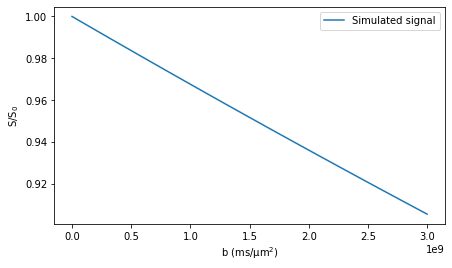

In [8]:
# Define substrate type and sphere radius in the substrate dictionary

substrate = {'type' : 'sphere',
             'radius' : 5e-6}


# Run simulation

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Show signal decay

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(bs, signals/n_s)
ax.legend(['Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()


### Diffusion in an ellipsoid

Initiating simulation. Step length = 3.11E-06
Simulation finished.


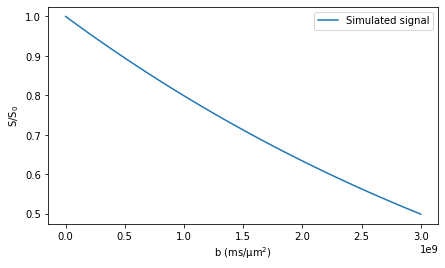

In [9]:
# Define a rotation matrix that defines the orientation of the ellipsoid

R = vec2vec_rotmat(np.array([1,0,0]),
                   np.array([1,-2,3])/np.linalg.norm(np.array([1,-2,3])))


# Define substrate type and properties

substrate = {'type' : 'ellipsoid',
             'a' : 20e-6, # Ellipsoid semi-axis along x axis
             'b' : 5e-6, # Ellipsoid semi-axis along y axis
             'c' : 10e-6, # Ellipsoid semi-axis along z axis
             'R' : R}


# Run simulation

signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Show signal decay

fig, ax = plt.subplots(1, figsize=(7,4))
ax.plot(bs, signals/n_s)
ax.legend(['Simulated signal'])
ax.set_xlabel('b (ms/μm$^2$)')
ax.set_ylabel('S/S$_0$')
plt.show()

Initiating simulation. Step length = 3.11E-06
Simulation finished.


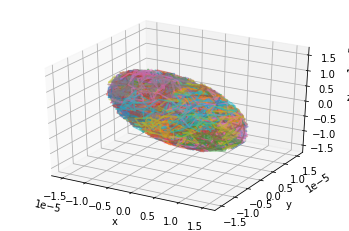

In [10]:
# Run simulation with a low number of spins and show trajectories

signals = simulations.simulation(int(1e2), diffusivity, gradient, dt, substrate,
                                 trajectories='example_traj.txt')

fig, ax = utils.show_traj('example_traj.txt')

### Diffusion in an infinite cylinder

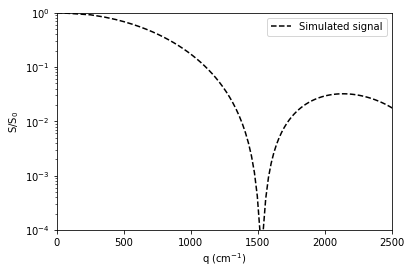

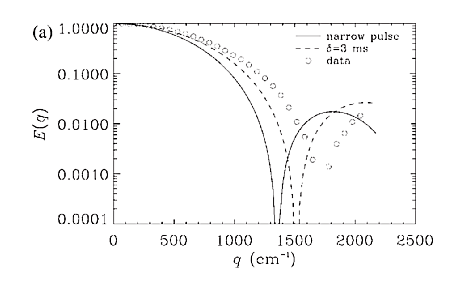

In [33]:
# Simulate diffusion in a cylinder and recreate the diffraction pattern reported
# in Figure 2A in "Three-dimensional water diffusion in impermeable cylindrical
# tubes: theory versus experiments" by Avram et al., 2008.


# Define simulation parameters

n_s = int(1e6) # Number of random walkers
n_t = int(1e4) # Number of time points
bs = np.linspace(0, 1000e9, 100) # b-values
diffusivity = 2e-9 # In units of m^2/s


# Define gradient array with Δ = 400 ms, δ = 3 ms

delta = 3e-3
DELTA = 400e-3
T = DELTA + delta
gradient = np.zeros((1, 4030, 3))
gradient[0,1:29,0] = 1
gradient[0,4001:4029,0] = -1
gradient = np.concatenate([gradient for _ in bs], axis=0)
dt = T/(gradient.shape[1]-1)
gradient, dt = gradients.interpolate_gradient(gradient, dt, n_t)
gradient = gradients.set_b(gradient, dt, bs)
delta = np.sum(gradient[-1,:,:] > 0)*dt
DELTA = np.min(np.where(gradient[-1,:,0]<0))*dt
q = gradients.calc_q(gradient, dt)
qs = np.max(np.linalg.norm(q, axis=2), axis=1)


# Run simulation

substrate = {'type' : 'cylinder',
             'orientation' : np.array([0, 0, 1]),
             'radius' : 4.5e-6}
signals = simulations.simulation(n_s, diffusivity, gradient, dt, substrate)


# Plot signal attenuation

fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(qs*1e-2/(2*np.pi), signals/n_s, ls='--',
        color='black')
ax.legend(['Simulated signal'])
ax.set_xlabel('q (cm$^{-1}$)')
ax.set_ylabel('S/S$_0$')
ax.set_yscale('log')
ax.set_ylim([1e-4,1])
ax.set_xlim([0,2500])
plt.show()


# Show figure from Avram et al. for comparison

fig, ax = plt.subplots(1, figsize=(8,6))
ax.imshow(mpimg.imread('disimpy/tests/avram2008_figure_2a.png'),
          interpolation='nearest')
fig.patch.set_visible(False)
ax.axis('off')
plt.show()
